# Test Caputo Integration

## Import Statements

In [3]:
from caputo import caputo_euler
from math import gamma
from matplotlib import pyplot as plt
import numpy as np

## Constant Case

Similar to an integer derivative, the Caputo derivative of a constant is zero.

$
\begin{align*}
_{t_{0}}^{\mathrm{C}}\mathrm{D}_{x}^{\alpha}[c] &= 0
\end{align*}
$

In [11]:
# Test constant
alpha = 0.5
t0 = 0
tf = 1
num_step = 1000
y0 = 1

f = lambda t, y: 0

ts, ys = caputo_euler(f, alpha, (t0, tf), num_step, y0)

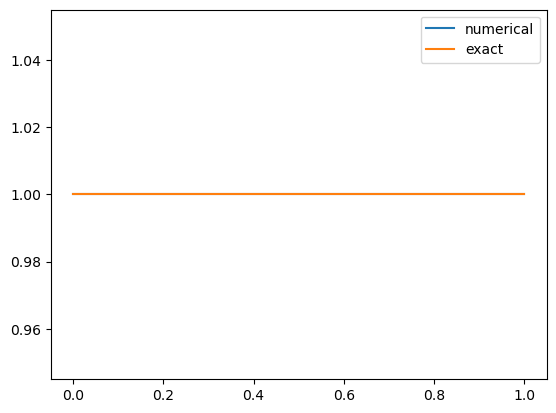

In [12]:
fig, ax = plt.subplots()
ax.plot(ts, ys, label='numerical')
ax.plot(ts, y0 * np.ones(ts.size), label='exact')
ax.legend()

## Polynomial Case

For $\lceil \alpha \rceil - 1 < b$,

$
\begin{align*}
_{t_{0}}^{\mathrm{C}}\mathrm{D}_{x}^{\alpha}[x^{b}] &=
\frac{\Gamma(b + 1)}{\Gamma(b - \alpha + 1)} (x^{b - \alpha} - t_{0}^{b - \alpha})
\end{align*}
$

Error convergence is done which confirms that the Caputo-Euler scheme is $\alpha$-order accurate.

In [5]:
# Test power of a function
alpha = 0.6
b = 3
t0 = 0
tf = 1
num_step = 1000
y0 = 0

f = lambda t, y, alpha=alpha, b=b: gamma(b + 1) / gamma(b - alpha + 1) * (t ** (b - alpha) - t0 ** (b - alpha))

ts, ys = caputo_euler(f, alpha, (t0, tf), num_step, y0)

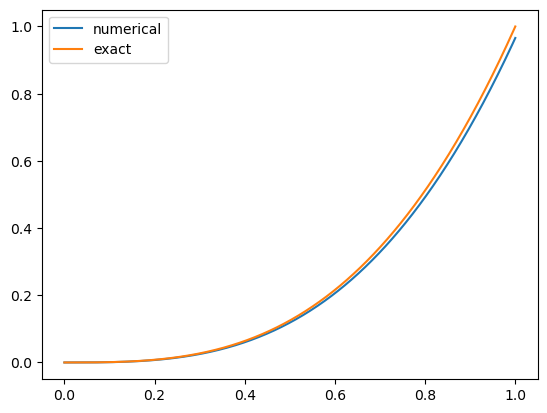

In [6]:
fig, ax = plt.subplots()
ax.plot(ts, ys, label='numerical')
ax.plot(ts, ts ** b, label='exact')
ax.legend()

In [40]:
# Error convergence study
alpha = 0.5
b = 3
t0 = 0
tf = 1
num_steps = [500, 1000, 2000, 4000, 8000]
errs = []
y0 = 0

f = lambda t, y, alpha=alpha, b=b: gamma(b + 1) / gamma(b - alpha + 1) * (t ** (b - alpha) - t0 ** (b - alpha))

for num_step in num_steps:
    ts, ys = caputo_euler(f, alpha, (t0, tf), num_step, y0)
    errs.append(abs(ys[-1] - 1))

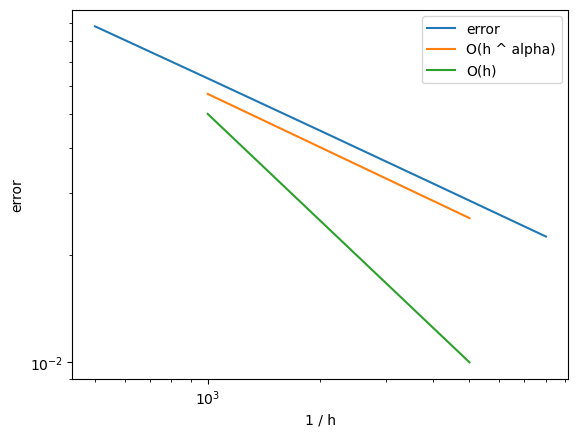

In [41]:
fig, ax = plt.subplots()
ns = np.linspace(1000, 5000, 11)
ax.loglog(num_steps, errs, label='error')
ax.loglog(ns, [1.8 / n ** alpha for n in ns], label='O(h ^ alpha)')
ax.loglog(ns, [50 / n for n in ns], label='O(h)')
ax.set_xlabel('1 / h')
ax.set_ylabel('error')
ax.legend()

## SEIRD Model Case

In [12]:
# Try SEIRD model
alpha = 0.9
beta = 0.25
sigma = 0.13
gam = 0.052
mu = 0.005
t0 = 0
tf = 500
num_step = 100
y0 = np.array([0.99, 0.01, 0, 0, 0])

f = lambda t, y: np.array([
    - beta * (y[0] * y[3]) / (1 - y[4]),
    beta * (y[0] * y[3]) / (1 - y[4]) - sigma * y[1],
    sigma * y[1] - (gam + mu) * y[2],
    gam * y[2],
    mu * y[2]
])

ts, ys = caputo_euler(f, alpha, (t0, tf), num_step, y0)

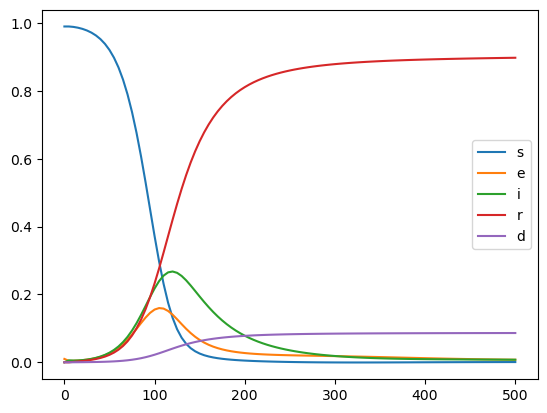

In [13]:
fig, ax = plt.subplots()
ax.plot(ts, ys[:, 0], label='s')
ax.plot(ts, ys[:, 1], label='e')
ax.plot(ts, ys[:, 2], label='i')
ax.plot(ts, ys[:, 3], label='r')
ax.plot(ts, ys[:, 4], label='d')
ax.legend()

In [26]:
# Error convergence study
alpha = 0.9
beta = 0.25
sigma = 0.13
gam = 0.052
mu = 0.005
t0 = 0
tf = 500
num_steps = [100, 200, 400, 800, 1600]
errs = []
y0 = np.array([0.99, 0.01, 0, 0, 0])

tss = []
yss = []

f = lambda t, y: np.array([
    - beta * (y[0] * y[3]) / (1 - y[4]),
    beta * (y[0] * y[3]) / (1 - y[4]) - sigma * y[1],
    sigma * y[1] - (gam + mu) * y[2],
    gam * y[2],
    mu * y[2]
])

# Ground truth
ts_coarse = np.linspace(t0, tf, 101)
ts_true, ys_true = caputo_euler(f, alpha, (t0, tf), 3200, y0)
tss.append(ts_true)
yss.append(ys_true)
interp_func = lambda fp_slice: np.interp(ts_coarse, ts_true, fp_slice)
ys_true = np.apply_along_axis(interp_func, 0, ys_true)

for num_step in num_steps:
    ts, ys = caputo_euler(f, alpha, (t0, tf), num_step, y0)
    tss.append(ts)
    yss.append(ys)
    interp_func = lambda fp_slice: np.interp(ts_coarse, ts, fp_slice)
    ys = np.apply_along_axis(interp_func, 0, ys)
    errs.append(sum([np.trapezoid((ys[:, i] - ys_true[:, i]) ** 2, x=ts_coarse) for i in range(5)]) ** 0.5)
    i += 1

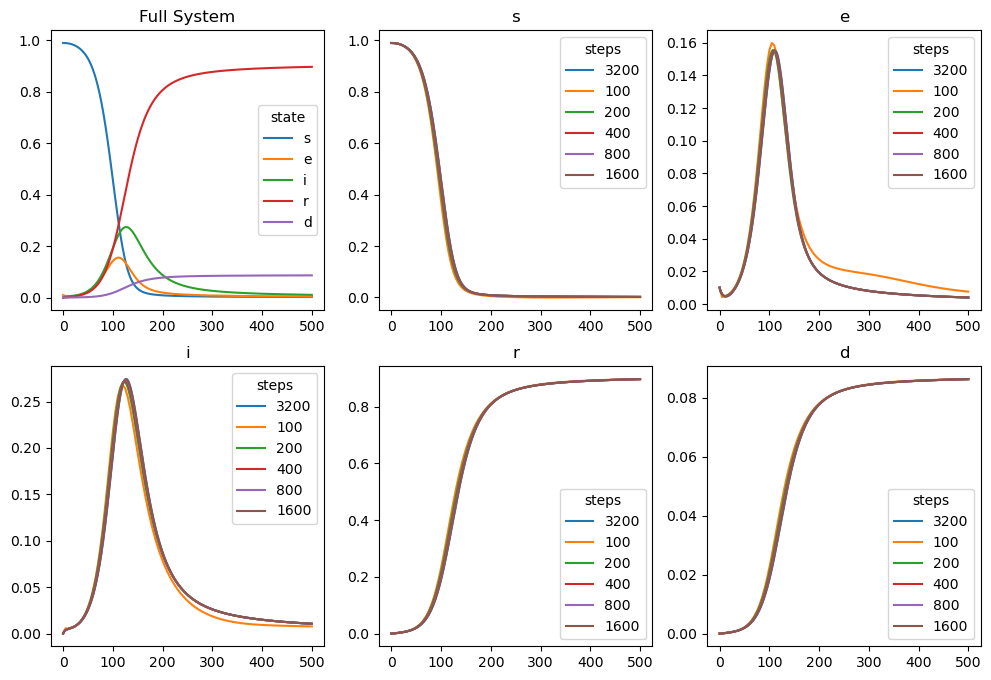

In [43]:
# Plot solutions
fig, ax = plt.subplots(2, 3, figsize=(12, 8))
labels = ['Full System', 's', 'e', 'i', 'r', 'd']
labels2 = ['3200', '100', '200', '400', '800', '1600']

# High-accuracy solution
for i in range(5):
    ax[0, 0].plot(tss[0], yss[0][:, i], label=labels[i + 1])

for j in range(len(tss)):
    for i in range(5):
        ax[(i + 1) // 3, (i + 1) % 3].plot(tss[j], yss[j][:, i], label=labels2[j])

for i in range(6):
    ax[i // 3, i % 3].set_title(labels[i])
    ax[i // 3, i % 3].legend(title=('state' if i == 0 else 'steps'))

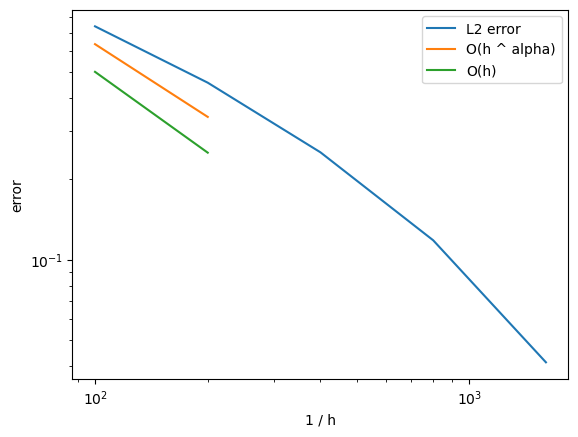

In [39]:
fig, ax = plt.subplots()
ns = np.linspace(100, 200, 11)
ax.loglog(num_steps, errs, label='L2 error')
ax.loglog(ns, [40 / n ** alpha for n in ns], label='O(h ^ alpha)')
ax.loglog(ns, [50 / n for n in ns], label='O(h)')
ax.set_xlabel('1 / h')
ax.set_ylabel('error')
ax.legend()